In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
babs = pd.read_csv('data/201508_trip_data.csv.gz')

In [3]:
def convert_date(date_str):
    try:
        return datetime.datetime.strptime(date_str, '%m/%d/%Y %H:%M')
    except ValueError:
        return None

In [4]:
babs['Start Date'] = babs['Start Date'].apply(convert_date)

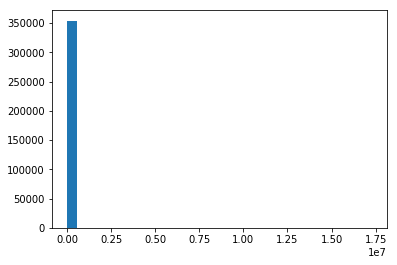

In [13]:
plt.hist(babs.Duration, bins=30)
None

In [14]:
sd, mu = babs.Duration.std(), babs.Duration.mean()

In [15]:
babs['z'] = (babs.Duration - mu) / sd

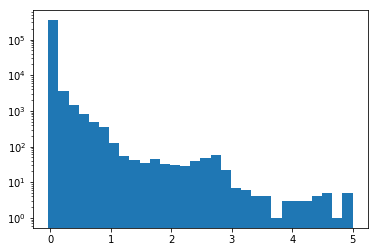

In [16]:
plt.hist(babs.z[babs.z < 5], bins=30)
plt.yscale('log')

In [5]:
babs['date'] = babs['Start Date'].apply(lambda x: x.date())

In [6]:
babs['hour'] = babs['Start Date'].apply(lambda x: x.hour)

In [7]:
counts = babs.groupby(['date', 'hour'], as_index=False)['Trip ID'].count()

In [44]:
X = counts.pivot_table(columns='hour', values='Trip ID', index='date').fillna(0)

In [45]:
X.head()

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
date,,,,,,,,,,,,,,,,,,,,,
2014-09-01,3.0,0.0,0.0,1.0,2.0,1.0,1.0,4.0,13.0,16.0,...,49.0,28.0,23.0,25.0,7.0,19.0,12.0,9.0,4.0,0.0
2014-09-02,0.0,1.0,0.0,0.0,2.0,4.0,31.0,113.0,181.0,152.0,...,43.0,51.0,111.0,198.0,141.0,52.0,24.0,12.0,9.0,9.0
2014-09-03,0.0,1.0,1.0,1.0,1.0,9.0,34.0,124.0,218.0,139.0,...,46.0,47.0,107.0,209.0,151.0,69.0,22.0,17.0,13.0,7.0
2014-09-04,2.0,0.0,0.0,0.0,3.0,7.0,37.0,107.0,195.0,125.0,...,47.0,56.0,122.0,191.0,125.0,51.0,29.0,23.0,19.0,6.0
2014-09-05,2.0,2.0,0.0,2.0,2.0,7.0,25.0,104.0,190.0,123.0,...,41.0,52.0,119.0,164.0,110.0,37.0,29.0,9.0,13.0,9.0


In [46]:
from sklearn.cluster import KMeans

In [55]:
ks = range(2, 10)
scores = [-KMeans(k).fit(X).score(X) for k in ks]

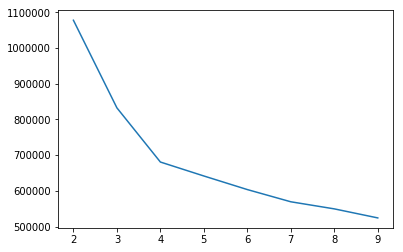

In [56]:
plt.plot(ks, scores)

In [57]:
model = KMeans(4).fit(X)

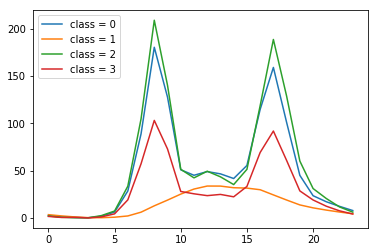

In [59]:
for n, center in enumerate(model.cluster_centers_):
    plt.plot(center, label="class = {}".format(n))
plt.legend()

In [61]:
labels = pd.DataFrame({'date': X.index, 'cluster': model.labels_})

In [181]:
from calendar import day_abbr, month_abbr

In [182]:
labels['day'] = labels.date.apply(lambda x: day_abbr[x.weekday()])
labels['month'] = labels.date.apply(lambda x: month_abbr[x.month])

In [183]:
weekday_counts = labels.groupby(['cluster', 'day']).cluster.count()

In [184]:
weekday_counts

cluster  day
0        Fri    44
         Mon     6
         Thu    13
         Tue     6
         Wed     6
1        Fri     4
         Mon     3
         Sat    52
         Sun    52
         Thu     4
         Wed     2
2        Mon    41
         Thu    34
         Tue    42
         Wed    39
3        Fri     4
         Mon     3
         Thu     1
         Tue     4
         Wed     5
Name: cluster, dtype: int64

In [185]:
weekday_counts.name = 'count'

In [186]:
better_counts = weekday_counts.reset_index().pivot(columns='day', values='count', index='cluster').fillna(0)
better_counts

day,Fri,Mon,Sat,Sun,Thu,Tue,Wed
cluster,,,,,,,
0,44.0,6.0,0.0,0.0,13.0,6.0,6.0
1,4.0,3.0,52.0,52.0,4.0,0.0,2.0
2,0.0,41.0,0.0,0.0,34.0,42.0,39.0
3,4.0,3.0,0.0,0.0,1.0,4.0,5.0


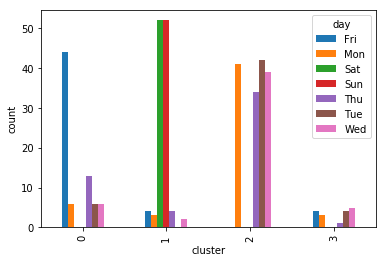

In [197]:
better_counts.plot.bar()
plt.ylabel('count')

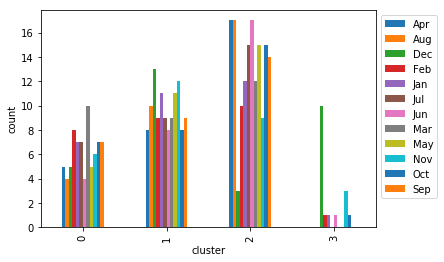

In [196]:
(labels
 .groupby(['cluster', 'month'])
 .day.count().reset_index()
 .pivot(columns='month', values='day', index='cluster')
 .fillna(0)
 .plot.bar())
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel('count')

In [90]:
hours = X.columns

In [127]:
X['center'] = [model.cluster_centers_[i] for i in model.labels_]
X['cluster'] = model.labels_

In [100]:
from numpy.linalg import norm

In [123]:
X['dist'] = [norm(i - j) for i, j in zip(X[hours].values, X['center'])]

In [135]:
stats = X.groupby(model.labels_)['dist'].agg([np.mean, np.std])

In [138]:
joined = X.join(stats, on='cluster')

In [141]:
joined['z'] = (joined.dist - joined['mean'])/joined['std']

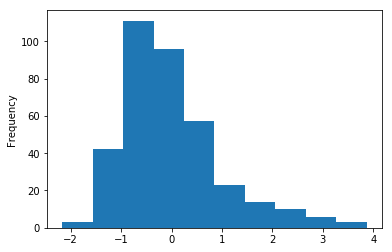

In [143]:
joined.z.plot.hist()

In [157]:
joined[joined.z > 3]

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,center,dist,cluster,mean,std,z
date,,,,,,,,,,,,,,,,,,,,,
2014-10-20,2.0,0.0,2.0,0.0,1.0,4.0,38.0,108.0,241.0,77.0,...,31.0,13.0,3.0,6.0,"[2.24358974359, 0.929487179487, 0.397435897436...",76.601566,2,40.115539,9.430631,3.868885
2014-12-11,1.0,2.0,0.0,1.0,1.0,0.0,6.0,11.0,15.0,9.0,...,6.0,2.0,2.0,2.0,"[3.67521367521, 2.34188034188, 1.2735042735, 0...",76.780584,1,33.481062,12.180384,3.554857
2015-06-01,0.0,0.0,1.0,0.0,4.0,6.0,26.0,70.0,155.0,132.0,...,27.0,21.0,18.0,3.0,"[2.24358974359, 0.929487179487, 0.397435897436...",76.587757,2,40.115539,9.430631,3.867421


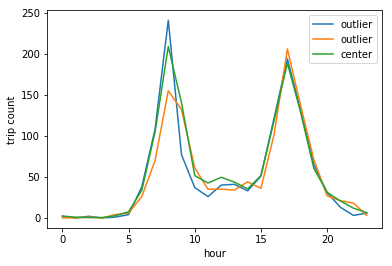

In [169]:
for i in joined[(joined.z > 3.5) & (joined.cluster == 2)][list(hours)].iterrows():
    plt.plot(i[1], label='outlier')
plt.plot(model.cluster_centers_[2], label='center')
plt.legend()
plt.xlabel('hour')
plt.ylabel('trip count')

In [9]:
?counts.apply

In [20]:
hourly = babs.groupby('Start Date').size().resample('1h').sum().fillna(0)

In [21]:
hourly.name = 'count'
#hourly = hourly.reset_index()

In [24]:
?pd.DataFrame

In [28]:
shifts = {'1h': 1, '1d': 24, '1w': 24*6, '28d': 24*28}

In [26]:
hourly.shift(1).head()

Start Date
2014-09-01 00:00:00    NaN
2014-09-01 01:00:00    3.0
2014-09-01 02:00:00    0.0
2014-09-01 03:00:00    0.0
2014-09-01 04:00:00    1.0
Freq: H, Name: count, dtype: float64

In [30]:
data = pd.DataFrame({k: hourly.shift(shifts[k]) for k in shifts})

In [31]:
data['curr'] = hourly

In [35]:
data = data.dropna()

In [32]:
from sklearn.ensemble import RandomForestRegressor

In [36]:
data.index.min()

Timestamp('2014-09-29 00:00:00', freq='H')

In [37]:
data.index.max()

Timestamp('2015-08-31 23:00:00', freq='H')

In [47]:
train, test = data[:'2015-08-21'], data['2015-08-21':]

In [48]:
model = RandomForestRegressor().fit(train[shifts.keys()], train.curr)

In [49]:
pred = pd.Series(model.predict(test[shifts.keys()]), index=test.index)

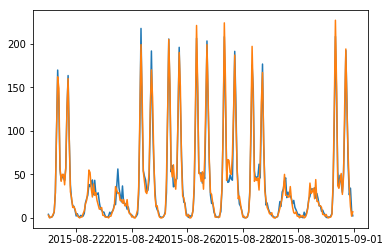

In [50]:
plt.plot(pred)
plt.plot(test.curr)

In [51]:
diffs = pred - test.curr

In [53]:
mu, sd = diffs.mean(), diffs.std()

In [54]:
mu

-0.60459024158210306

In [55]:
zs = (diffs - mu)/sd

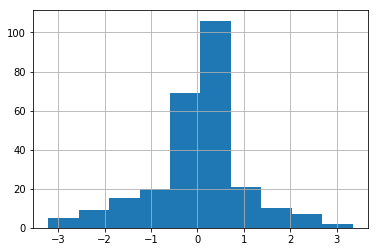

In [56]:
zs.hist()

In [57]:
zs[zs.abs() > 3]

Start Date
2015-08-23 12:00:00    3.182292
2015-08-27 15:00:00   -3.214421
2015-08-28 14:00:00    3.348010
dtype: float64

In [58]:
pred['2015-08-28 14:00:00']

61.700000000000003

In [59]:
test.curr['2015-08-28 14:00:00']

32.0

In [63]:
plt.rcParams['figure.figsize'] = 15, 12

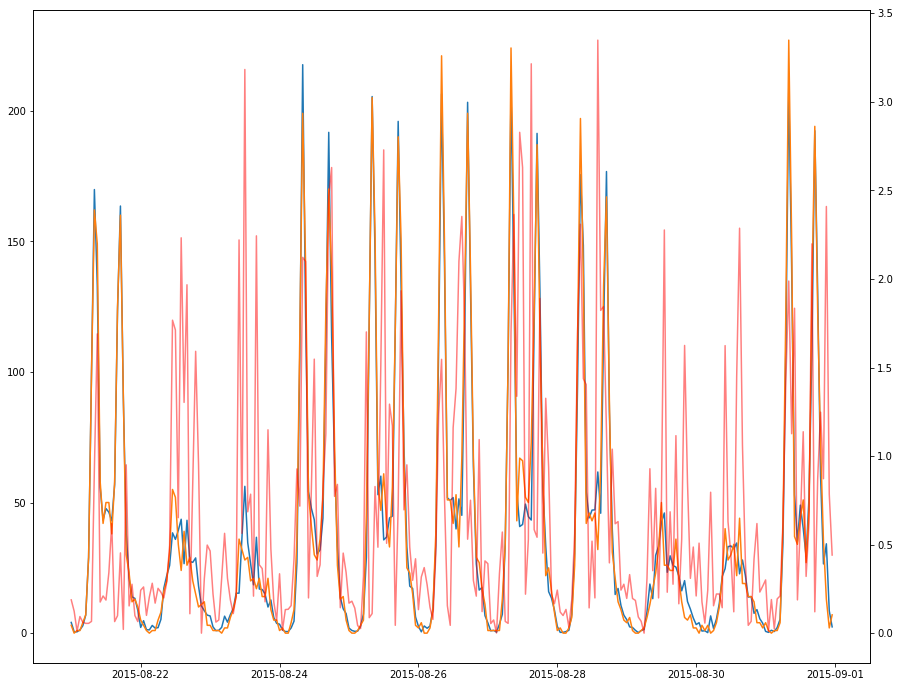

In [68]:
plt.plot(pred)
plt.plot(test.curr)
plt.gca().twinx().plot(zs.abs(), color='red', alpha=0.5)